# GPU Value Function Iteration under Uncertainty

Introducing uncertainty in the simple RBC model through the mean of a Markov process is a standard way of creating a model with a stochastic component: we will discuss the case in which productivity of the capital is not fixed, but instead fluctuates stochastically between $N = 3$ states.

Obviously, since we now have $N$ potential states of nature at each point in time, it is necessary to study the value function of all of these possible world. More specifically, if we think in terms of the policy function, solving the model is equivalent to knowing what the right policy choice for each capital value **and** for each possible state of nature.

Suppose there are 3 productivity states

$z \, = \, [0.5, 1, 1.5]$

and the transition matrix between these states is

$ P \, = \,
 \begin{pmatrix}
  0.80 & 0.15 & 0.05 \\
  0.08 & 0.84 & 0.08  \\
  0.05 & 0.15 & 0.80 \\
 \end{pmatrix} $
 
Thus, there will be 3 value functions to compute, namely

$\text{V}_{z = 0.5}(k) \quad \text{V}_{z = 1}(k) \quad \text{V}_{z = 1.5}(k)$

such that we have 

$\mathbb{E}\left[\text{V}_{z_i}(k)\right] \, = \, \sum_{j = 1}^{3}{\left[ P_{i,j}\cdot \text{V}_{x_j}(k) \right]}$

### Setting up the Model

As seen before, consider the (stochastic) RBC model

$ \text{V}(k) \; = \; \underset{k'}{\max} \left\{ \frac{c_t^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}[\text{V}(k')] \right\} \quad \text{s.t.} \quad {k' = z\, k^{\alpha} + (1-\delta)k - c } $

where:
- $\alpha$ = 0.33;
- $\beta$ = 0.96;
- $\delta$ = 0.1 i.e. there is no full capital depreciation;
- $\sigma$ = 2 as parameter of CRRA utility;

Also, the upper bound for the capital grid is now `ub = 15`, because the steady state of the high-productivity economy has higher capital than before.

In [1]:
include("matrixPrint.jl")

alpha = 0.33;
beta = 0.96;

delta = 0.1;
sigma = 2;

# Stochastic process:
z = Array{Float32}([0.5 1 1.5]);
# Transition matrix:
P = Array{Float32}(
    [0.80 0.15 0.05;
     0.08 0.84 0.08;
     0.05 0.15 0.80]);

# Lower bound for the capital grid:
lb = 0.001;
# Upper bound for the capital grid: 
ub = 15;
# Number of grid points:
grid_size = 1000;
# Create an evenly spaced capital grid:
grid_w = Array{Float32}(collect(linspace(lb, ub, grid_size)));

matprint(z)
matprint(P)

Array{Float32,2} [1:1, 1:3]
[
	0.500	1.000	1.500
];
Array{Float32,2} [1:3, 1:3]
[
	0.800	0.150	0.050
	0.080	0.840	0.080
	0.050	0.150	0.800
];


### Value Function Iteration on the CPU

In [2]:
function cpu_vfi_stochastic(grid_::Array{Float32}, alpha, beta, delta, sigma, z, P, maxiter_)
    
    SIZE_GRID = size(grid_,1);
    SIZE_Z    = length(z);
    
    V0 = Array{Float32}(ones(SIZE_GRID, SIZE_Z));
    V  = Array{Float32}(ones(SIZE_GRID, SIZE_Z));
    # We will store the policy function:
    policy = Array{Float32}(zeros(SIZE_GRID, SIZE_Z));
    
    """
    # Precompute the utility-of-consumption matrix:
    tmp_V = Array{Float32}(zeros(SIZE_GRID, SIZE_GRID, SIZE_Z));
    
    for i in 1:SIZE_GRID
        for z_ind in 1:SIZE_Z
            tmp = z[z_ind]*grid_[i]^alpha + (1-delta)*grid_[i] .- grid_;
            tmp[tmp .< 0] = -Inf;
            tmp[tmp .> 0] = (tmp[tmp .> 0].^(1-sigma) .- 1)./(1-sigma);
            tmp_V[i, :, z_ind] = tmp;
        end
    end
    """
    
    for it in 1:maxiter_
        
        # For every point on the capital grid:
        for i in 1:SIZE_GRID
            # For every state of productivity:
            for z_ind in 1:SIZE_Z
                # Compute consumption for all possible k':
                tmp = z[z_ind]*grid_[i]^alpha + (1-delta)*grid_[i] .- grid_;
                tmp_max = -Inf;
                pol_ind_tmp = 1;
                # For every possible value of consumption:
                for (j, point_j) in enumerate(tmp)
                    # If consumption is positive:
                    if point_j > 0
                        # U(c(k, k')) + beta * E[V(k')]:
                        tmp_comp = (point_j^(1-sigma) - 1)/(1-sigma) + beta*dot(P[z_ind, :], V0[j, :]);
                        # Find the max, and save the index for policy:
                        if tmp_comp > tmp_max
                            tmp_max = tmp_comp;
                            pol_ind_tmp = j;
                        end
                    end
                end
                V[i, z_ind] = tmp_max;
                policy[i, z_ind] = pol_ind_tmp;
            end
        end
        
        V0 = copy(V);
            
    end
    
    
    return V, policy
        
end

cpu_vfi_stochastic (generic function with 1 method)

### Value Function Iteration on the GPU (CLArrays)

In [3]:
using CLArrays, GPUArrays

function gpu_vfi_stochastic(grid_::Array{Float32}, alpha, beta, delta, sigma, z_, P_, maxiter_)
    
    SIZE_GRID = size(grid_, 1);
    SIZE_Z    = length(z_);
    
    V      = ones(CLArray{Float32}, SIZE_GRID, SIZE_Z);
    policy = zeros(CLArray{UInt32}, SIZE_GRID, SIZE_Z);
    grid   = CLArray(grid_);
    z      = CLArray(z_);
    P      = CLArray(P_);
    
    for iter_ in 1:maxiter_
    
    # Write kernel for GPU manually:
    gpu_call(grid, (grid, V, policy, z, P, Float32(alpha), Float32(beta), Float32(delta), Float32(sigma), UInt32(SIZE_GRID), UInt32(SIZE_Z))) do state, grid, V, policy, z, P, alpha, beta, delta, sigma, SIZE_GRID, SIZE_Z
        # Each kernel executes for one value of the capital grid:
        idx = @linearidx grid
        #@inbounds begin
            # For every state of productivity:
            for index_z in 1:SIZE_Z
                tmp_max = Float32(-Inf);
                pol_ind_tmp = UInt32(1);
                # For every possible value of k':
                for i in 1:SIZE_GRID
                    # Compute consumption for k' = grid(i):
                    tmp = z[index_z]*grid[idx]^alpha + (1-delta)*grid[idx] - grid[i];
                    # If consumption is positive:
                    if tmp > 0
                        # U(c(k, k')) + beta * E[V(k')]:
                        tmp = ((tmp)^(1-sigma)-1) / (1-sigma);
                        for j in 1:SIZE_Z
                            tmp = tmp + beta*P[index_z, j]*V[i, j];
                        end
                    end
                    # Find the max, and save the index for policy:
                    if tmp > tmp_max
                        tmp_max = tmp;
                        pol_ind_tmp = UInt32(i);
                    end
                end
                V[idx, index_z] = tmp_max;
                policy[idx, index_z] = pol_ind_tmp;
            end
        #end   
        return
    end
        
    end
    
    return V, policy
        
end

gpu_vfi_stochastic (generic function with 1 method)

### GPU vs CPU code perfomance

First the execute the CPU code to compute the value function and the policy function:

In [4]:
cpu_time = @elapsed CPU_OUT, CPU_POLICY = cpu_vfi_stochastic(grid_w, alpha, beta, delta, sigma, z, P, 200)
println("Value Function:")
matprint(Array{Float16}(CPU_OUT))
println("Policy:")
matprint(CPU_POLICY)
println("Exectime: ", cpu_time, " seconds")

Value Function:
Array{Float16,2} showing [1:8/1000, 1:3]
[
	-51.031	-23.922	-14.453
	-28.688	-13.281	-7.172
	-24.953	-11.406	-5.867
	-22.844	-10.344	-5.125
	-21.344	-9.602	-4.613
	-20.219	-9.031	-4.211
	-19.297	-8.570	-3.891
	-18.52	-8.17	-3.617
	...	...	...
];
Policy:
Array{Float32,2} showing [1:8/1000, 1:3]
[
	2.000	2.000	3.000
	4.000	7.000	10.000
	5.000	9.000	14.000
	7.000	11.000	17.000
	8.000	13.000	19.000
	9.000	15.000	22.000
	10.000	17.000	24.000
	11.0	18.0	26.0
	...	...	...
];
Exectime: 74.732921542 seconds


1000-element Array{Float32,1}:
 -51.0239 
 -28.6831 
 -24.9498 
 -22.8478 
 -21.3515 
 -20.214  
 -19.2937 
 -18.5218 
 -17.8555 
 -17.2692 
 -16.7469 
 -16.2746 
 -15.8432 
   ⋮      
   4.72638
   4.73051
   4.73464
   4.73876
   4.74289
   4.747  
   4.75112
   4.75523
   4.75932
   4.7634 
   4.76748
   4.77156

Then we plot the result:

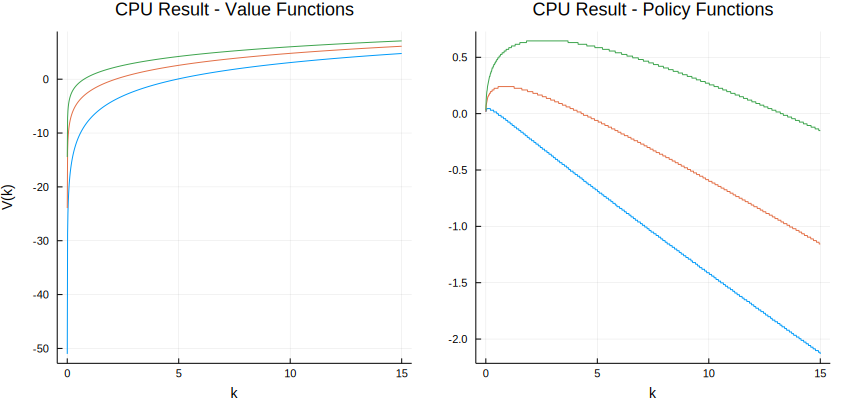

In [26]:
CPU_POLICY_W = Array{Float32}(zeros(size(CPU_POLICY)))
for i in 1:length(z)
    CPU_POLICY_W[:,i] = grid_w[Array{UInt32}(CPU_POLICY[:,i])]-grid_w
end

using Plots; gr()
# Plots.scalefontsizes(0.5)

p1 = plot(grid_w, CPU_OUT, yaxis="V(k)", xaxis="k", title="CPU Result - Value Functions")
p2 = plot(grid_w, CPU_POLICY_W, xaxis="k", title="CPU Result - Policy Functions")
plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

We do the same for the GPU code (running it 2 times):

In [22]:
cl_device = CLArrays.devices()[1]
CLArrays.init(cl_device)

OpenCL context with:
CL version: OpenCL 1.2 
Device: CL Intel(R) Iris(TM) Graphics 550
            threads: 256
             blocks: (256, 256, 256)
      global_memory: 1610.612736 mb
 free_global_memory: NaN mb
       local_memory: 0.065536 mb


In [30]:
gpu_time = @elapsed GPU_OUT, GPU_POLICY = gpu_vfi_stochastic(grid_w, alpha, beta, delta, sigma, z, P, 200)
println("Value Function:")
matprint(Array{Float16}(GPU_OUT))
println("Policy:")
matprint(Array{UInt32}(GPU_POLICY))
println("Exectime: ", gpu_time, " seconds")

Value Function:
Array{Float16,2} showing [1:8/1000, 1:3]
[
	-51.031	-23.922	-14.453
	-28.688	-13.281	-7.172
	-24.953	-11.406	-5.867
	-22.844	-10.344	-5.129
	-21.359	-9.602	-4.613
	-20.219	-9.031	-4.215
	-19.297	-8.570	-3.891
	-18.52	-8.17	-3.617
	...	...	...
];
Policy:
Array{UInt32,2} showing [1:8/1000, 1:3]
[
	2.000	2.000	3.000
	4.000	7.000	10.000
	5.000	9.000	14.000
	7.000	11.000	17.000
	8.000	13.000	19.000
	9.000	15.000	22.000
	10.000	17.000	24.000
	11	18	26
	...	...	...
];
Exectime: 0.012965051 seconds


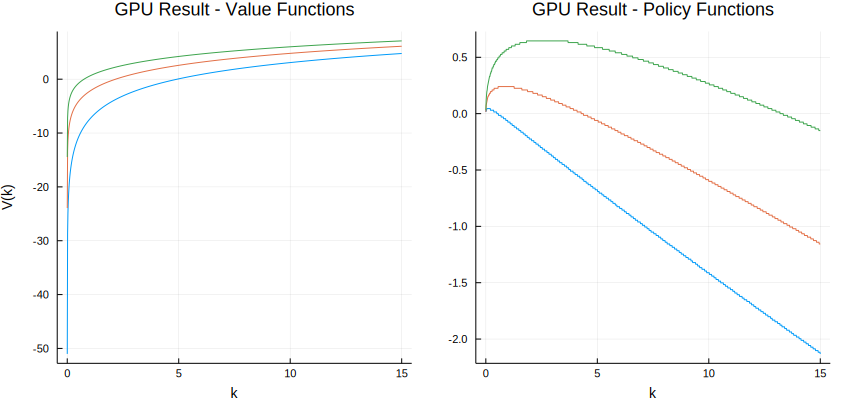

In [27]:
GPU_OUT = Array{Float64}(GPU_OUT)
GPU_POLICY = Array{UInt32}(GPU_POLICY)

GPU_POLICY_W = Array{Float32}(zeros(size(GPU_POLICY)))
for i in 1:length(z)
    GPU_POLICY_W[:,i] = grid_w[Array{UInt32}(GPU_POLICY[:,i])]-grid_w
end

p1 = plot(grid_w, GPU_OUT, yaxis="V(k)", xaxis="k", title="GPU Result - Value Functions")
p2 = plot(grid_w, GPU_POLICY_W, xaxis="k", title="GPU Result - Policy Functions")
plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

Finally, we compare the GPU and the CPU results, computing the relative error for both the value function and the policy function:

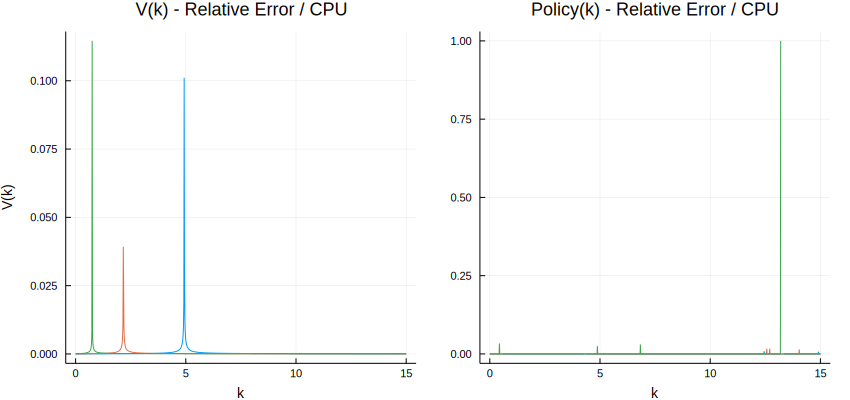

In [28]:
p1 = plot(grid_w, abs.((GPU_OUT-CPU_OUT)./CPU_OUT), yaxis="V(k)", xaxis="k", title="V(k) - Relative Error / CPU")
p2 = plot(grid_w, abs.((GPU_POLICY_W-CPU_POLICY_W)./CPU_POLICY_W), xaxis="k", title="Policy(k) - Relative Error / CPU")
plot(p1, p2, layout=(1,2), legend=false, size=(850,400))

When comparing execution times, the GPU (once the code is compiled and the memory has been allocated) is many around 4 orders of magnitude faster than the CPU at executing the VFI:

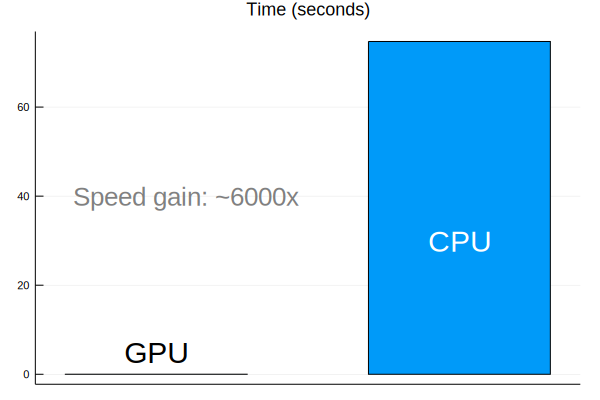

CPU time: 74.75 seconds
GPU time: 0.01296 seconds


In [31]:
println("CPU time: ", Float16(cpu_time), " seconds")
println("GPU time: ", Float16(gpu_time), " seconds")

bar([1,2], [gpu_time, cpu_time], xticks=[1, 2], bar_width=0.6, 
        legend=false, title="Time (seconds)", xticks=[])
annotate!([(1, 5, text("GPU",20,:center)),
          (2, 30, text("CPU",20,:white,:center)),
          (1.1, 40, text("Speed gain: ~6000x",18,:left,:grey,:center))])